In [1]:
# This file is associated with the book
# "Machine Learning Refined", Cambridge University Press, 2016.
# by Jeremy Watt, Reza Borhani, and Aggelos Katsaggelos.

import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

A simple data loading function.

In [2]:
# import training data 
def load_data(csvname):
    # load in data
    data = np.asarray(pd.read_csv(csvname))

    # import data and reshape appropriately
    X = data[:,0:-1]
    y = data[:,-1]
    y.shape = (len(y),1)
    
    # pad data with ones for more compact gradient computation
    o = np.ones((np.shape(X)[0],1))
    X = np.concatenate((o,X),axis = 1)
    X = X.T
    
    return X,y

All of the functionality required to perform Newton's method on the squared margin cost function.

In [3]:
###### for squared margin cost #######
# function for computing gradient and Hessian for squared margin cost Newton's method
def squared_margin_grad_hess(X,y,w):
    hess = 0
    grad = 0
    for p in range(0,len(y)):
        # precompute        
        x_p = X[:,p]
        y_p = y[p]
        
        # update grad and hessian
        grad+= -2*max(0,1 - y_p*np.dot(x_p.T,w))*y_p*x_p
        
        if 1 - y_p*np.dot(x_p.T,w) > 0:
            hess+= 2*np.outer(x_p,x_p)
        
    grad.shape = (len(grad),1)
    return grad,hess

# run newton's method
def squared_margin_newtons_method(X,y,w):
    # begin newton's method loop    
    max_its = 20
    misclass_history = []
    for k in range(max_its):
        # compute gradient and Hessian
        grad,hess = squared_margin_grad_hess(X,y,w)

        # take Newton step
        hess = hess + 10**-3*np.diag(np.ones((np.shape(X)[0])))
        temp = np.dot(hess,w) - grad        
        w = np.dot(np.linalg.pinv(hess),temp)

        # update history container
        cost = count_misclasses(X,y,w)
        misclass_history.append(cost)
    return misclass_history

All of the functionality required to perform Newton's method on the softmax or logistic regression cost function.

In [4]:
###### for softmax cost ######
# function for computing gradient and Hessian for Newton's method
def softmax_grad_hess(X,y,w):
    hess = 0
    grad = 0
    for p in range(0,len(y)):
        # precompute
        x_p = X[:,p]
        y_p = y[p]
        s = 1/(1 + my_exp(y_p*np.dot(x_p.T,w)))
        g = s*(1-s)
        
        # update grad and hessian
        grad+= -s*y_p*x_p
        hess+= np.outer(x_p,x_p)*g
        
    grad.shape = (len(grad),1)
    return grad,hess

# run newton's method
def softmax_newtons_method(X,y,w):
    # begin newton's method loop
    max_its = 20
    misclass_history = []
    
    for k in range(max_its):
        # compute gradient and Hessian
        grad,hess = softmax_grad_hess(X,y,w)
        
        # take Newton step
        hess = hess + 10**-3*np.diag(np.ones((np.shape(X)[0])))
        temp = np.dot(hess,w) - grad
        w = np.dot(np.linalg.pinv(hess),temp)
        
        # update container for cost history
        cost = count_misclasses(X,y,w)
        misclass_history.append(cost)
    return misclass_history

# avoid overflow when using exp - just cutoff after arguments get too large/small
def my_exp(u):
    s = np.argwhere(u > 100)
    t = np.argwhere(u < -100)
    u[s] = 0
    u[t] = 0
    u = np.exp(u)
    u[t] = 1
    return u

Finally, a short function to count misclassifications - which we call at each step of Newton's method for both softmax and squared margin to measure effecacy.

In [5]:
# function for counting the number of misclassifications
def count_misclasses(X,y,w):
    y_pred = np.sign(np.dot(X.T,w))
    num_misclassed = len(y) - len([i for i, j in zip(y, y_pred) if i == j])
    return num_misclassed

With everything defined we can now run all - and compare our two models on this dataset.

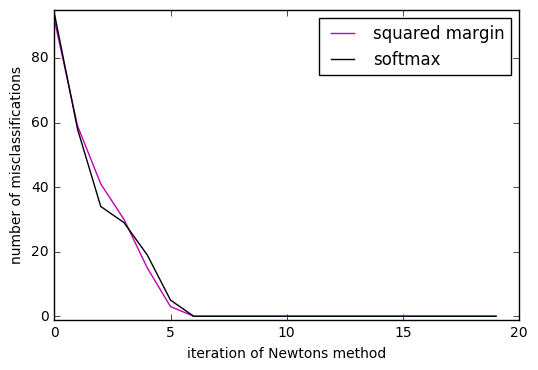

In [6]:
###### run functions above #######

# load data
X,y = load_data('feat_face_data.csv')

# run newtons method to minimize squared margin or SVM cost
w0 = np.random.randn(np.shape(X)[0],1)
squared_margin_history = squared_margin_newtons_method(X,y,w0)

# run newtons method to minimize logistic regression or softmax cost
# w0 = np.zeros((np.shape(X)[0],1))
softmax_cost_history = softmax_newtons_method(X,y,w0)

# plot results
plt.plot(squared_margin_history,color = 'm')
plt.plot(softmax_cost_history,'k')

# clean up plot
plt.ylim([min(min(squared_margin_history),min(softmax_cost_history)) - 1,max(max(squared_margin_history),max(softmax_cost_history)) + 1])
plt.xlabel('iteration of Newtons method')
plt.ylabel('number of misclassifications')
plt.legend(['squared margin','softmax'])
plt.show()